# MusicLab Copenhagen Audience motion measurements, preparations

After combining MusicLab app accelerometer measurements:

and aligning measurements with the imbedded synchronisation taps in mobile phone measurements (MusicLab) and AX3 sensors: 

This notebook characterises the initial measurements patterns of gaps, the scaling of the AX3 sensor values, and the downsampling of all measurements into an aligned set of instantaneous jerk measurements. 


In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [3]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [4]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [5]:
internal_Part = general_loc + 'Participants_internal/'

In [6]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [7]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # A in person hall participants, B remote participants 
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
print(len(aligned_Part_Codes))
alignedParts.iloc[:5,:]

115


,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [9]:
# concert times 50 Hz This is the original sample rate on which the compensation for ax3 sensors were evaluated
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [10]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
bad_gaps = []
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
#     print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
#         aud_df.loc[:,part] = b
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

143.2305428981781
143.31755805015564


# Participants by location
Note: this is the only not published information about the audience used in the Audience motion paper.

In [11]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
alignedParts = partDets.loc[~partDets['Aligned_DevID'].isna(),:]


In [12]:
D = pd.DataFrame(index=aud_df.index,columns=aud_df.columns)
for c in aud_df.columns:
    D.loc[aud_df[c].isna(),c]=1
#exclude the interval from coverage percentate
coverage = pd.concat([D.loc[:concert_times.loc[23,'Datetime'],:],D.loc[concert_times.loc[24,'Datetime']:,:]],axis=0) 

partDets.set_index('Participant_Code',inplace=True)
partDets['Z'] = coverage.sum()/len(coverage)
partDets.reset_index(inplace=True)

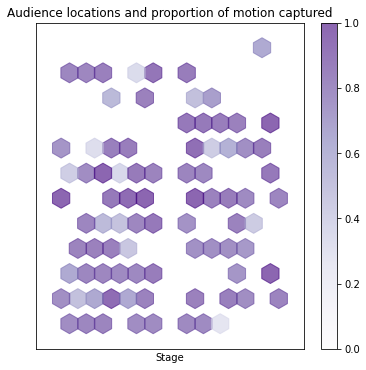

In [13]:
plt.figure(figsize=[6,6])
sc=plt.scatter(x=partDets['Y'],y=partDets['X'], c=1-partDets['Z'], cmap='Purples',vmin=0,vmax=1, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.colorbar(sc)
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title('Audience locations and proportion of motion captured')
# show the graph
# plt.savefig('./plots/Audience_Devices_Aligned.png',dpi = 300)
plt.show()

In [14]:
Near_Rels = pd.read_csv('./data/Audience/Near_Participants_Hall.csv')

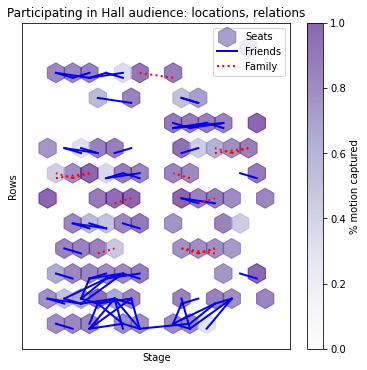

In [15]:
plt.figure(figsize=[6,6])
sc=plt.scatter(x=partDets['Y'],y=partDets['X'], c=1-partDets['Z'], cmap='Purples',vmin=0,vmax=1, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.colorbar(sc,label='% motion captured')

plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title('Participating in Hall audience: locations, relations')

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]

ship = Friends.iloc[0,:]
P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'b',linewidth = 2)
ship = Family.iloc[0,:]
P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'r',linewidth = 2,linestyle=':')    
    
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'b',linewidth = 2)


for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.2,P2['X']]),'r',linewidth = 2,linestyle=':')

plt.legend(['Seats','Friends','Family'])
plt.ylabel('Rows')
# show the graph
plt.savefig('./plots/Inhall_Audience_Locations.png',dpi = 196)
plt.show()

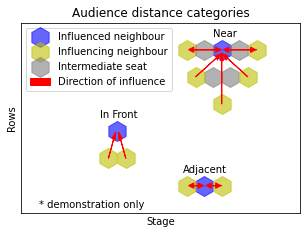

In [16]:
plt.figure(figsize=[5,3.5])

# in front influence
sc=plt.scatter(x=[3.5],y=[7],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[1.5,5.5],y=[7,7],c ='y', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[2.5,4.5],y=[7,7],c ='grey', s=400, marker="h", alpha=0.6)

plt.arrow(3.5,7,-1.6,0,color='r',head_width=0.2)

plt.legend(['Influenced neighbour','Influencing neighbour','Intermediate seat','Direction of influence'],
          loc='upper left')
sc=plt.scatter(x=[3.0,4.0],y=[6,6],c ='grey', s=400, marker="h", alpha=0.6)

plt.arrow(1.75,7,1.4,0,color='r',head_width=0.2)

plt.arrow(5.5,7,-1.6,0,color='r',head_width=0.2)
plt.arrow(3.75,7,1.4,0,color='r',head_width=0.2)

sc=plt.scatter(x=[2.0,5.0],y=[6,6],c ='y', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[3.5],y=[5],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(2.0,6,1.2,0.7,color='r',head_width=0.2)
plt.arrow(5.0,6,-1.2,0.7,color='r',head_width=0.2)
plt.arrow(3.5,5,0,1.6,color='r',head_width=0.2)

plt.annotate('Near',[3,7.5],)

# adjancents influence
sc=plt.scatter(x=[2.5],y=[2],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[1.5,3.5],y=[2,2],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(2.5,2,-0.6,0,color='r',head_width=0.2)
plt.arrow(1.75,2,0.4,0,color='r',head_width=0.2)
plt.arrow(3.5,2,-0.6,0,color='r',head_width=0.2)
plt.arrow(2.75,2,0.4,0,color='r',head_width=0.2)
plt.annotate('Adjacent',[1.25,2.5],)

# in front influence
sc=plt.scatter(x=[-2.5],y=[4],c ='b', s=400, marker="h", alpha=0.6)
sc=plt.scatter(x=[-2.0,-3.0],y=[3,3],c ='y', s=400, marker="h", alpha=0.6)
plt.arrow(-2.0,3,-0.3,0.7,color='r',head_width=0.2)
plt.arrow(-3.0,3,0.3,0.7,color='r',head_width=0.2)
plt.annotate('In Front',[-3.5,4.5],)

plt.annotate('* demonstration only',[-7,1.2],)
plt.xlim([-8,8])
plt.ylim([1,8])
# plt.colorbar(sc,label='% motion captured')

plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title('Audience distance categories')
plt.ylabel('Rows')
plt.savefig('./plots/Spatial_relationships.png',dpi = 196)
plt.show()